/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/home/eng/workspace/ML-wireless-signal-classification/src/ml_wireless_classification/base/SignalUtils.py:175: RuntimeWarning: invalid value encountered in log
  decay_rate = -np.gradient(np.log(normalized_autocorr + 1e-10))


AM vs. Non-AM Classification Report:
              precision    recall  f1-score   support

      Non-AM       0.69      0.75      0.72     36112
          AM       0.66      0.59      0.63     29888

    accuracy                           0.68     66000
   macro avg       0.68      0.67      0.67     66000
weighted avg       0.68      0.68      0.68     66000



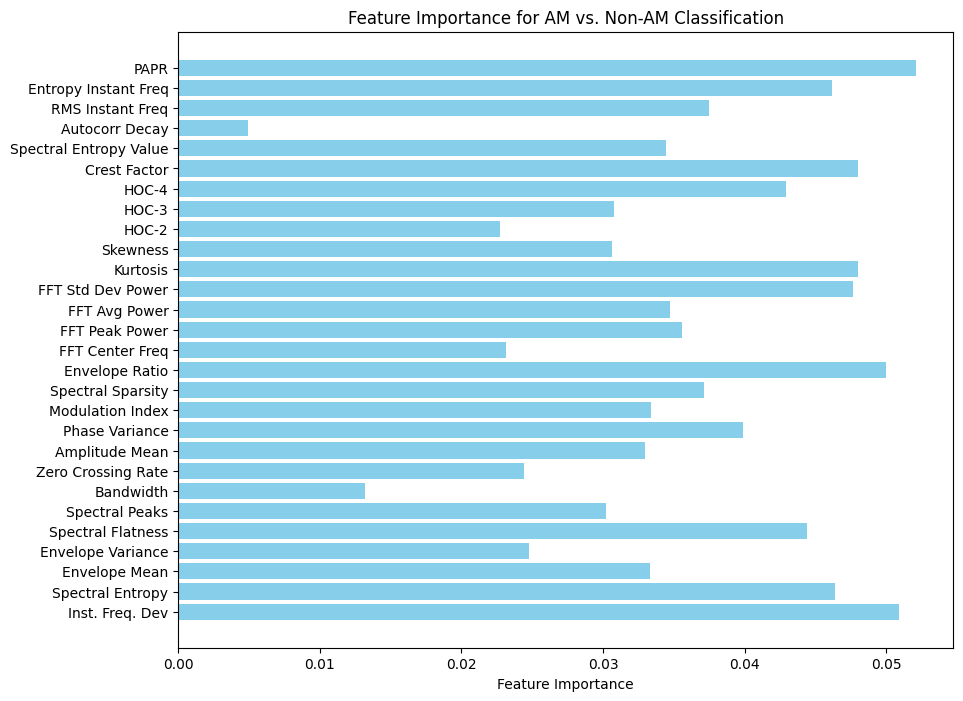

In [9]:
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from ml_wireless_classification.base.SignalUtils import (
    compute_instantaneous_features, compute_modulation_index, compute_spectral_asymmetry,
    instantaneous_frequency_deviation, spectral_entropy, envelope_mean_variance,
    spectral_flatness, spectral_peaks_bandwidth, zero_crossing_rate, compute_fft_features,
    autocorrelation, is_digital_signal, compute_kurtosis, compute_skewness,
    compute_spectral_energy_concentration, compute_instantaneous_frequency_jitter,
    compute_spectral_kurtosis, compute_higher_order_cumulants, compute_crest_factor,
    compute_spectral_entropy, compute_energy_spread, compute_autocorrelation_decay,
    compute_rms_of_instantaneous_frequency, compute_entropy_of_instantaneous_frequency,
    compute_envelope_variance, compute_papr
)

# Global dictionary to store feature names and values
feature_dict = {}

def add_feature(name, func, *args):
    """Try to add a feature by checking the shape and ensuring it’s a scalar."""
    try:
        value = func(*args)
        # If value is an array, check if it is scalar (single value)
        if np.isscalar(value) or (isinstance(value, np.ndarray) and value.size == 1):
            feature_dict[name] = value.item() if isinstance(value, np.ndarray) else value
        else:
            print(f"Warning: Feature '{name}' has incorrect shape and was not added.")
    except Exception as e:
        print(f"Error computing feature '{name}': {e}")

def extract_features(data):
    features = []
    labels = []

    for key, signals in data.items():
        mod_type, snr = key
        for signal in signals:
            real_part, imag_part = signal[0], signal[1]
            complex_signal = real_part + 1j * imag_part
            
            # Reset feature dictionary for each signal
            global feature_dict
            feature_dict = {}

            # Add features with validation
            add_feature("Inst. Freq. Dev", instantaneous_frequency_deviation, complex_signal)
            add_feature("Spectral Entropy", spectral_entropy, real_part)
            add_feature("Envelope Mean", lambda x: envelope_mean_variance(x)[0], real_part)
            add_feature("Envelope Variance", lambda x: envelope_mean_variance(x)[1], real_part)
            add_feature("Spectral Flatness", spectral_flatness, real_part)
            add_feature("Spectral Peaks", lambda x: spectral_peaks_bandwidth(x)[0], real_part)
            add_feature("Bandwidth", lambda x: spectral_peaks_bandwidth(x)[1], real_part)
            add_feature("Zero Crossing Rate", zero_crossing_rate, real_part)
            add_feature("Amplitude Mean", lambda x: np.mean(compute_instantaneous_features(x)[0]), real_part)
            add_feature("Phase Variance", lambda x: np.var(compute_instantaneous_features(x)[1]), real_part)
            add_feature("Modulation Index", compute_modulation_index, real_part)
            add_feature("Spectral Sparsity", compute_spectral_asymmetry, real_part)
            add_feature("Envelope Ratio", lambda x: envelope_mean_variance(x)[0] / (envelope_mean_variance(x)[1] + 1e-10), real_part)
            add_feature("FFT Center Freq", lambda x: compute_fft_features(x)[0], real_part)
            add_feature("FFT Peak Power", lambda x: compute_fft_features(x)[1], real_part)
            add_feature("FFT Avg Power", lambda x: compute_fft_features(x)[2], real_part)
            add_feature("FFT Std Dev Power", lambda x: compute_fft_features(x)[3], real_part)
            add_feature("Kurtosis", compute_kurtosis, real_part)
            add_feature("Skewness", compute_skewness, real_part)
            add_feature("HOC-2", lambda x: compute_higher_order_cumulants(x, order=2), real_part)
            add_feature("HOC-3", lambda x: compute_higher_order_cumulants(x, order=3), real_part)
            add_feature("HOC-4", lambda x: compute_higher_order_cumulants(x, order=4), real_part)
            add_feature("Crest Factor", compute_crest_factor, real_part)
            add_feature("Spectral Entropy Value", compute_spectral_entropy, real_part)
            add_feature("Autocorr Decay", compute_autocorrelation_decay, real_part)
            add_feature("RMS Instant Freq", compute_rms_of_instantaneous_frequency, real_part)
            add_feature("Entropy Instant Freq", compute_entropy_of_instantaneous_frequency, real_part)
            add_feature("Envelope Variance", compute_envelope_variance, real_part)
            add_feature("PAPR", compute_papr, real_part)

            # Append the feature values and label
            features.append(list(feature_dict.values()))
            labels.append(mod_type)

    return np.array(features), labels

# Load the RML2016.10a_dict.pkl file with explicit encoding
with open("../RML2016.10a_dict.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")

# Feature extraction for all signals
features, labels = extract_features(data)

# Convert labels to binary for AM vs. Non-AM classification
is_am_label = ["AM" in label for label in labels]

# Split the dataset into training and testing sets for AM vs. Non-AM classification
X_train_am, X_test_am, y_train_am, y_test_am = train_test_split(features, is_am_label, test_size=0.3, random_state=42)

# Initialize and train a classifier for AM vs. Non-AM classification
clf_am = RandomForestClassifier(n_estimators=100, random_state=42)
clf_am.fit(X_train_am, y_train_am)

# Predict and evaluate the AM vs. Non-AM classifier
y_pred_am = clf_am.predict(X_test_am)
print("AM vs. Non-AM Classification Report:")
print(classification_report(y_test_am, y_pred_am, target_names=["Non-AM", "AM"]))

# Feature importance for AM vs. Non-AM classification
feature_names = list(feature_dict.keys())
importances_am = clf_am.feature_importances_
plt.figure(figsize=(10, 8))
plt.barh(feature_names, importances_am, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance for AM vs. Non-AM Classification")
plt.show()
